# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [6]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate

In [7]:
filename="../Lab.7/SUSY.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

In [7]:
import sklearn
print(sklearn.__version__)


1.6.1


### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [8]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [9]:
N_Train=4000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [5]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

We can plot the output, comparing signal and background:

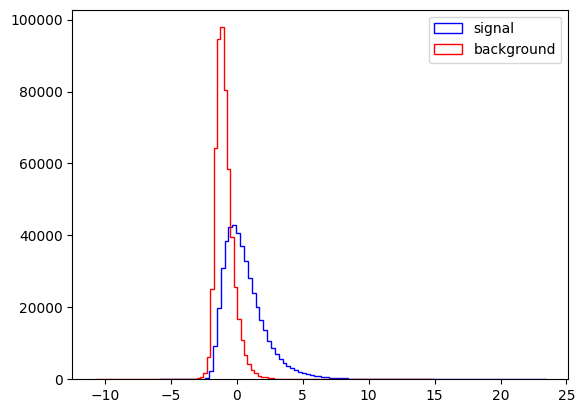

In [6]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]),bins=100,histtype="step", color="blue", label="signal",stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]),bins=100,histtype="step", color="red", label="background",stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

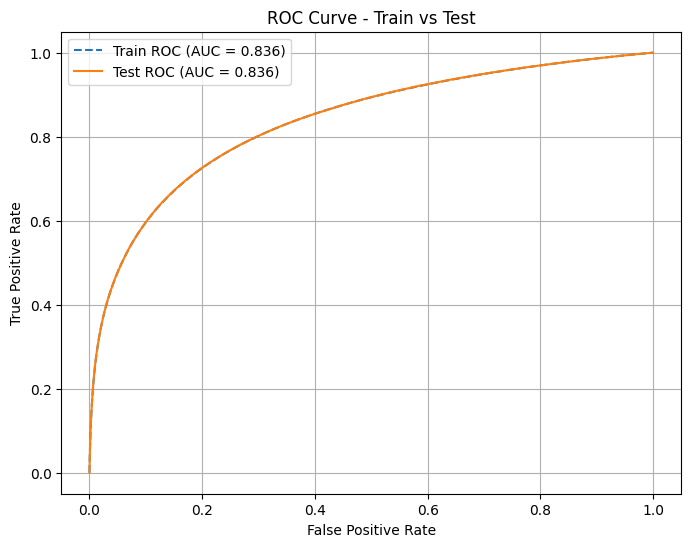

In [10]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import sklearn.discriminant_analysis as DA

# Instantiate classifier
Fisher = DA.LinearDiscriminantAnalysis()

# Define samples
N_Train = 4000000
Train_Sample = df[:N_Train]
Test_Sample = df[N_Train:]

X_Train = Train_Sample[VarNames[1:]]
y_Train = Train_Sample["signal"]

X_Test = Test_Sample[VarNames[1:]]
y_Test = Test_Sample["signal"]

# Train classifier
Fisher.fit(X_Train, y_Train)

# Compute scores
y_train_scores = Fisher.decision_function(X_Train)
y_test_scores = Fisher.decision_function(X_Test)

# ROC curves
fpr_train, tpr_train, _ = roc_curve(y_Train, y_train_scores)
fpr_test, tpr_test, _ = roc_curve(y_Test, y_test_scores)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, label='Train ROC (AUC = {:.3f})'.format(auc(fpr_train, tpr_train)), linestyle='--')
plt.plot(fpr_test, tpr_test, label='Test ROC (AUC = {:.3f})'.format(auc(fpr_test, tpr_test)), linestyle='-')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Train vs Test')
plt.legend()
plt.grid(True)
plt.show()

We do not observe a bias between the train and test ROC curves. The model performs the same on both the training and unseen test data, suggesting it generalizes well and is not overfitting.

#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

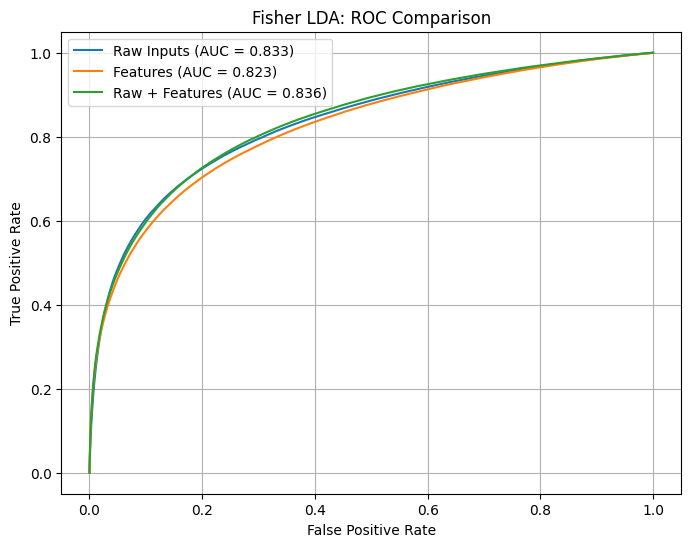

In [14]:
# Define the sets of variables
RawVars = ["l_1_pT", "l_1_eta", "l_1_phi", 
           "l_2_pT", "l_2_eta", "l_2_phi", 
           "MET", "MET_phi"]
FeatureVars = ["MET_rel", "axial_MET", "M_R", "M_TR_2", "R", 
               "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawFeatureVars = RawVars + FeatureVars

# Function to train and compute ROC
def get_roc(fisher_model, df, input_vars):
    X_train = df[:N_Train][input_vars]
    y_train = df[:N_Train]["signal"]
    X_test = df[N_Train:][input_vars]
    y_test = df[N_Train:]["signal"]
    
    fisher_model.fit(X_train, y_train)
    y_scores = fisher_model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

# Run for all input sets
Fisher = DA.LinearDiscriminantAnalysis()
fpr_raw, tpr_raw, auc_raw = get_roc(Fisher, df, RawVars)

Fisher = DA.LinearDiscriminantAnalysis()
fpr_feat, tpr_feat, auc_feat = get_roc(Fisher, df, FeatureVars)

Fisher = DA.LinearDiscriminantAnalysis()
fpr_both, tpr_both, auc_both = get_roc(Fisher, df, RawFeatureVars)

# Plot all
plt.figure(figsize=(8, 6))
plt.plot(fpr_raw, tpr_raw, label='Raw Inputs (AUC = {:.3f})'.format(auc_raw))
plt.plot(fpr_feat, tpr_feat, label='Features (AUC = {:.3f})'.format(auc_feat))
plt.plot(fpr_both, tpr_both, label='Raw + Features (AUC = {:.3f})'.format(auc_both))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Fisher LDA: ROC Comparison')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

In [2]:
# Part A
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=10, max_depth=10, n_jobs=-1),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=50, max_depth=3)
}

Evaluating Logistic Regression...


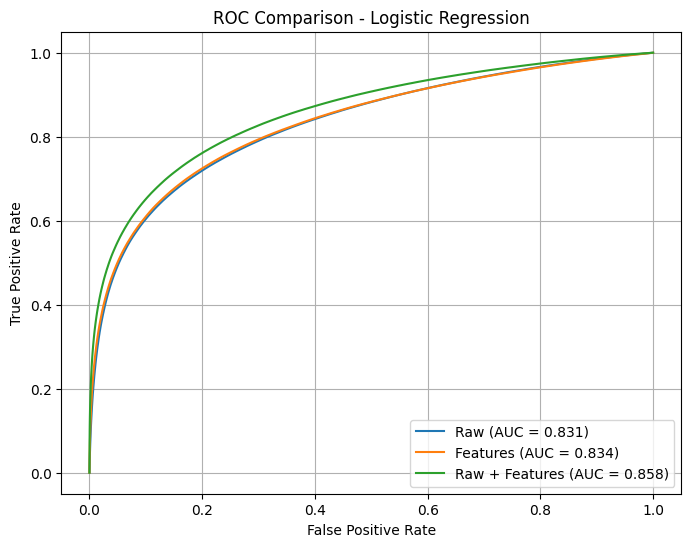

Evaluating Random Forest...


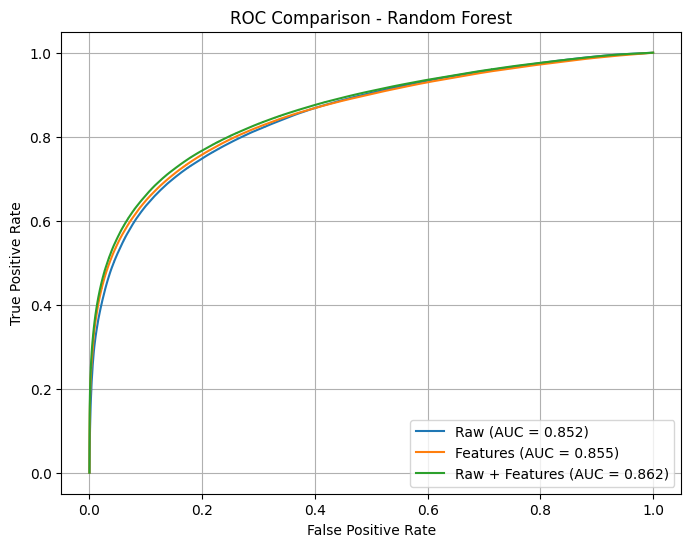

Evaluating Gradient Boosting...


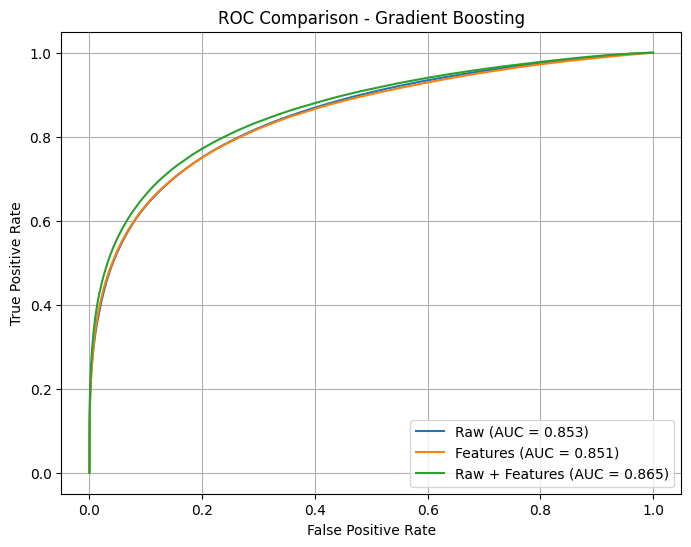

In [11]:
# Part B
from sklearn.metrics import roc_curve, auc

def compare_classifier(clf, df, RawVars, FeatureVars, N_Train=4000000):
    results = {}
    
    input_sets = {
        "Raw": RawVars,
        "Features": FeatureVars,
        "Raw + Features": RawVars + FeatureVars
    }

    for label, vars in input_sets.items():
        X_train = df[:N_Train][vars]
        y_train = df[:N_Train]["signal"]
        X_test = df[N_Train:][vars]
        y_test = df[N_Train:]["signal"]
        
        clf.fit(X_train, y_train)
        scores = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
        fpr, tpr, _ = roc_curve(y_test, scores)
        auc_score = auc(fpr, tpr)
        results[label] = (fpr, tpr, auc_score)

    return results

def plot_roc_comparison(results, title="ROC Comparison"):
    plt.figure(figsize=(8, 6))
    for label, (fpr, tpr, auc_score) in results.items():
        plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.3f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()
    
for name, clf in classifiers.items():
    print(f"Evaluating {name}...")
    #results = compare_classifier(clf, df, RawVars, FeatureVars)
    results = compare_classifier(clf, df, RawVars, FeatureVars, N_Train=500000)
    plot_roc_comparison(results, title=f"ROC Comparison - {name}")


In [8]:
# Part C
import numpy as np

RawVars = ["l_1_pT", "l_1_eta", "l_1_phi", 
           "l_2_pT", "l_2_eta", "l_2_phi", 
           "MET", "MET_phi"]
FeatureVars = ["MET_rel", "axial_MET", "M_R", "M_TR_2", "R", 
               "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
RawFeatureVars = RawVars + FeatureVars

def compute_max_significance(clf, df, input_vars, N_Train=4000000):
    X_test = df[N_Train:][input_vars]
    y_test = df[N_Train:]["signal"]
    
    # Get scores
    scores = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)

    thresholds = np.linspace(0, 1, 500)
    max_sigma = 0
    best_thresh = 0

    for t in thresholds:
        preds = scores > t
        N_S = ((preds == 1) & (y_test == 1)).sum()
        N_B = ((preds == 1) & (y_test == 0)).sum()
        
        if N_S + N_B > 0:
            sigma = N_S / np.sqrt(N_S + N_B)
            if sigma > max_sigma:
                max_sigma = sigma
                best_thresh = t

    return max_sigma, best_thresh

best_clf = GradientBoostingClassifier(n_estimators=100)
input_vars = RawVars + FeatureVars
best_clf.fit(df[:4000000][input_vars], df[:4000000]["signal"])

max_sig, best_cut = compute_max_significance(best_clf, df, input_vars)

print(f"Max Significance: {max_sig:.2f} at cut threshold: {best_cut:.2f}")


Max Significance: 524.52 at cut threshold: 0.39


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


In [14]:
from sklearn.metrics import (
    roc_curve, auc, precision_score, recall_score,
    f1_score, accuracy_score
)
import pandas as pd

def evaluate_classifier(clf, df, input_vars, N_Train=4000000, threshold=None):
    X_train = df[:N_Train][input_vars]
    y_train = df[:N_Train]["signal"]
    X_test = df[N_Train:][input_vars]
    y_test = df[N_Train:]["signal"]

    clf.fit(X_train, y_train)
    
    # Get scores
    if hasattr(clf, "predict_proba"):
        scores = clf.predict_proba(X_test)[:, 1]
    else:
        scores = clf.decision_function(X_test)

    # ROC & AUC
    fpr, tpr, thresholds = roc_curve(y_test, scores)
    roc_auc = auc(fpr, tpr)

    # Threshold
    if threshold is None:
        threshold = 0.5  # Default if not using best cut

    y_pred = scores > threshold

    # Basic metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Max significance
    max_sig, best_thresh = compute_max_significance(clf, df, input_vars, N_Train)

    # Return everything
    return {
        "AUC": roc_auc,
        "Precision": precision,
        "Recall (TPR)": recall,
        "F1 Score": f1,
        "Accuracy": accuracy,
        "Max Significance": max_sig,
        "Best Cut": best_thresh
    }
    
# Using Gradient Boosting + Raw + Features
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(n_estimators=50, max_depth=3)
input_vars = RawVars + FeatureVars

results = evaluate_classifier(clf, df, input_vars, N_Train=500000)

# Display in a nice table
display(pd.DataFrame([results], index=["Gradient Boosting"]))


,AUC,Precision,Recall (TPR),F1 Score,Accuracy,Max Significance,Best Cut
Gradient Boosting,0.864617,0.818967,0.70543,0.75797,0.79391,1102.764983,0.382766
